## Building Neural Network Model for Black-Scholes Pricing

---


|  |  |
|:---|:---|
|**Reading Time** |  10 minutes |
|**Packages used** | Defined with relevant DocStrings within repository   |
|**Outcome** | Trained NN model save in the directory ./model/output | 

---

### First step is to import all relevant packages to train neural network model. Note that Black-Scholes, in general is mostly used for computing greeks to effectively hedge risks associated with option positions

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import json

import warnings
warnings.filterwarnings("ignore") # just to remove clutter in the notebook

In [2]:
os.chdir("..")

In [3]:
from model.pricing.utils.get_data import get_current_price, pre_processing
from model.pricing.core.neural_network import run_nn_model
from model.pricing.core.black_scholes import create_dataset

### Second step does the following:- 

- Define data size, read ticker information, and retrieve current price for that ticker. As an example, I have used S&P500
- Create a diversified set of input parameters using Latin Hypercube sampling to cover range of possible input parameters
- Compute black scholes price and moneyness
- Read already tuned hyperparmeters. Method used to identify these hyper parameters was Random search using cross-validation

---

In [4]:
data_set_size = 1000000
df, st_current_price, range_of_inputs = pre_processing(data_set_size, "BS")
dt_set = create_dataset(df, st_current_price, range_of_inputs)

In [5]:
tuned_hyper_parameter_file_name = os.getcwd() + "/model/output/" + "best_hyper_parameter.json"
with open(tuned_hyper_parameter_file_name) as f:
    df_hyper = json.load(f)

### Third step does the following:- 

- Define columns used as input features and the target variable
- Run the model using the cycilical decaying learning rate, more detail is avaiable in the DocString of run_nn_model method
- Plot the loss on the training set and validation with each epoch
- The below plot demonstrates that model is not overfitting as loss is decreasing in both training and validation set

---

In [6]:
feature_columns = ['moneyness', 'time_to_maturity', 'risk_free_rate', 'volatility']
target = 'opt_price_by_strike'
model, training_history = run_nn_model(dt_set, df_hyper, feature_columns, target)

2023-01-29 10:42:35.147445: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


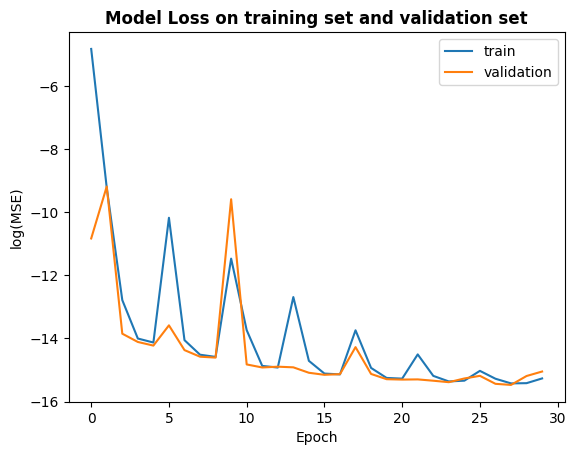

In [43]:
train_log_mse = [np.log(i) for i in training_history.history['mse']]
validation_log_mse = [np.log(i) for i in training_history.history['val_mse']]
plt.plot(train_log_mse)
plt.plot(validation_log_mse)
plt.title('Model Loss on training set and validation set', fontweight ="bold")
plt.ylabel('log(MSE)')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#### Last step is plot the error distribution on a new dataset and then to save the model in the ./model/output directory

In [8]:
test_data_set_size = 10000
df, st_current_price, range_of_inputs = pre_processing(test_data_set_size, "BS")
dt_test = create_dataset(df, st_current_price, range_of_inputs)

In [14]:
feature_columns = ['moneyness', 'time_to_maturity', 'risk_free_rate', 'volatility']
target = 'opt_price_by_strike'
x_test = dt_test[feature_columns]
y_test = dt_test[target]
y_predict = model.predict(x_test)

296/296 [==============================] - 0s 700us/step


In [33]:
y_test = np.array(y_test)
y_t = [y[0] for y in y_predict]
diff = np.subtract(y_test, y_t)

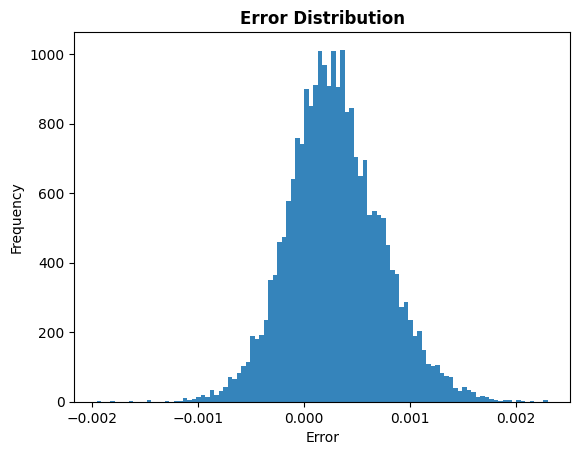

In [41]:
plt.hist(diff, 100, density=1, alpha=0.9)
plt.xlabel('Error')
plt.ylabel('Frequency')
  
plt.title('Error Distribution', fontweight ="bold")
plt.show()

In [44]:
model_save_path = os.getcwd() + "/model/output/" + "BS_NN_model.h5"
model.save(model_save_path)